In [1]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import numpy as np 
import pandas as pd
from scipy import stats
from sklearn import svm

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
sns.set_style('whitegrid')
sns.set_palette("Set1")

# Goal
Das Modell sollte Anträge identifizieren, bei denen eine "Charged Off" unwahrscheinlich ist, um kostspielige Fehler zu vermeiden. Es gibt zu viele Daten, um diese ohne einen erheblichen Zeitaufwand genau zu verstehen. Deshalb bieten sich hier Methoden des Maschinellen Lernens an. 

# Data Setup and Preprocessing

In [2]:
data_set = pd.read_csv("../../data/reduced_dataset.csv")
pd.set_option('display.max_columns', None)
data_set.shape

(421096, 76)

### Delete Samples with NaN

In [3]:
data_set = data_set.dropna()
data_set.shape

(326529, 76)

Falls hier eine größere Anzahl an Samples verloren gehen würden, könnte man die NaN-Werte durch andere Verfahren wie Extrapolieren, Mittelwert, etc. auffüllen

### Create Target Variable and Delet Samples with Status "Current"
Bei allen Loans mit dem Status Current ist nicht klar, ob diese zu einem guten oder schlechten Loan entwicklen. Deshalb lösche ich diese Samples.

In [4]:
def create_target_variable(attribute):
    if attribute == 'Fully Paid' or attribute == 'In Grace Period':
        return 0
    elif attribute == 'Current':
        return -1
    else:
        return 1
data_set['target'] = data_set['loan_status'].apply(create_target_variable)
data_set = data_set[data_set['target'] != -1]
data_set.drop(labels='loan_status', axis=1, inplace=True)
data_set.shape

(166731, 76)

### Reduce Purpose Feature

In [5]:
def new_purpose_attributes(attribute):
    if attribute=='debt_consolidation' or attribute=='credit_card':
        return 'refinance'
    elif attribute=='house' or attribute=='home_improvement' or attribute=='moving':
        return 'house'
    elif attribute=='car' or attribute=='major_purchase':
        return 'major_purchase'
    else:
        return 'other'
data_set['purpose'] = data_set['purpose'].apply(new_purpose_attributes)

### Drop Grade Feature
Ich schließe die Noten des Lending Clubs  aus. Sie werden wahrscheinlich mit Hilfe eines Clustering-Algorithmus generiert und würde einen künstlichen Einblick in die Kreditnehmer gewähren (Information Leakage) 

In [6]:
data_set.drop(labels='grade', axis=1, inplace=True)
data_set.shape

(166731, 75)

### Distribution of Target Variable

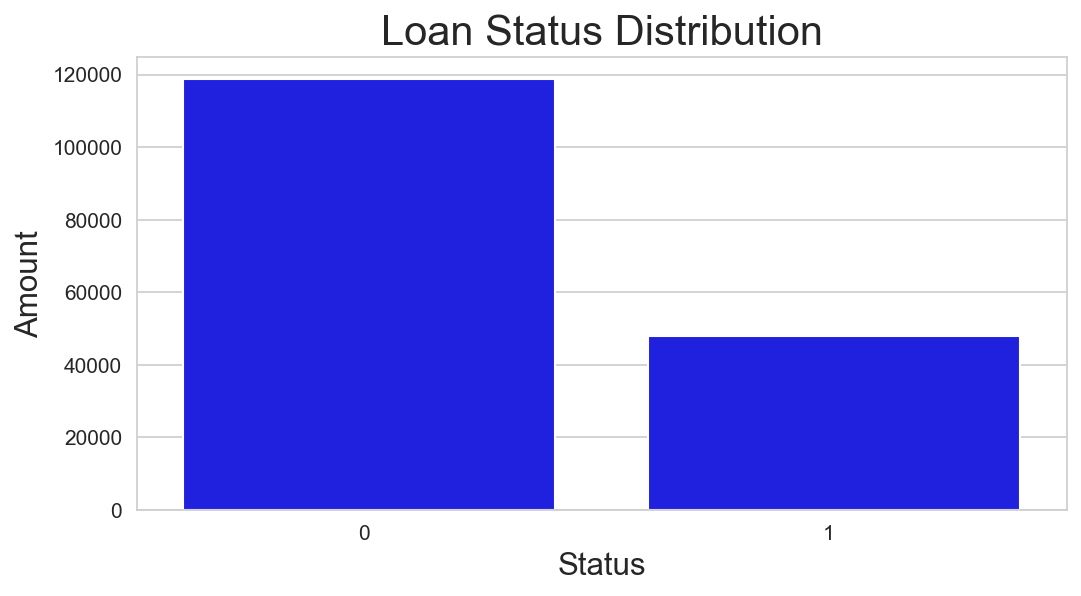

In [7]:
plt.figure(figsize=(8,4), dpi=150)
f=sns.countplot(x="target", data = data_set, order = data_set['target'].value_counts().index ,color='b')
f.set_xticklabels(f.get_xticklabels(),fontdict={'horizontalalignment':'right'})
f.set_xlabel("Status", fontsize=15)
f.set_ylabel("Amount", fontsize=15)
f.set_title("Loan Status Distribution", fontsize=20)
plt.show()

__Analyse__:
- Ich habe einen unbalanced Datensatz. Dies muss im folgenden berücksichtig werden. 

### Zero-Hot Encoding for Categorical Features

In [8]:
data_set = pd.get_dummies(data_set)
data_set.shape

(166731, 126)

### Create Test and Train Data Set

In [9]:
y = data_set['target'].to_numpy()
X = data_set.drop(['target'], axis=1).to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

### Standardize Features 

In [10]:
# Fit StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
# Transform data
train_scaled = scaler.transform(X_train)
test_scaled = scaler.transform(X_test)

- Es ist wichitg die Testdaten mit der Variance und dem Mittelwert der Trainingsdaten zu standardisieren, damit kein Information Leakage passiert

### Oversampling

In [11]:
oversampler = SMOTE(random_state=12)
train_scaled_os, y_train_os = oversampler.fit_sample(train_scaled, y_train)

# Support Vector Machine

In [12]:
clf_svm = svm.SVC()

In [ ]:
parameters = {'kernel': ['rbf'], 
              'gamma': [1e-3, 1e-4],
              'C': [10, 100, 1000]},
gsc = GridSearchCV(estimator=clf_svm, param_grid=parameters, scoring='f1')
gsc.fit(train_scaled_os, y_train_os)
best_params = gsc.best_params_

In [ ]:
clf_svm = svm.SVC(kernel="rbf", gamma=1e-3, C=100)
clf_svm.fit(train_scaled_os, y_train_os)

In [ ]:
y_hat = clf_svm.predict(test_scaled)

In [ ]:
# Evaluate Test Set
print("The F1 Score is: {}".format(f1_score(y_test, y_hat, average="binary")))
print("The Precision Score is: {}".format(precision_score(y_test, y_hat, average="binary")))
print("The Recall Score is: {}".format(recall_score(y_test, y_hat, average="binary")))
tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
print("TN: {}".format(tn))
print("FP: {}".format(fp))
print("FN: {}".format(fn))
print("TP: {}".format(tp))

# Decision Tree
## Grid Search for Hyperparameter

In [99]:
dt = DecisionTreeClassifier()

In [100]:
parameters = {
    'max_depth' : [5,20,50], 
    'min_samples_split' : [2, 8]
    }
gsc = GridSearchCV(estimator=dt, param_grid=parameters, scoring='f1')
gsc.fit(train_scaled_os, y_train_os)
best_params = gsc.best_params_

In [101]:
best_params

{'max_depth': 20, 'min_samples_split': 2}

## Train Model for Test Set

In [102]:
dt = DecisionTreeClassifier(max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'])
dt.fit(train_scaled_os, y_train_os)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=20, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

## Test Results

In [103]:
y_hat = dt.predict(test_scaled)

In [104]:
# Evaluate Test Set
print("The F1 Score is: {}".format(f1_score(y_test, y_hat, average="binary")))
print("The Precision Score is: {}".format(precision_score(y_test, y_hat, average="binary")))
print("The Recall Score is: {}".format(recall_score(y_test, y_hat, average="binary")))
tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
print("TN: {}".format(tn))
print("FP: {}".format(fp))
print("FN: {}".format(fn))
print("TP: {}".format(tp))

The F1 Score is: 0.9438650834623988
The Precision Score is: 0.9331064988091188
The Recall Score is: 0.954874651810585
TN: 34677
FP: 983
FN: 648
TP: 13712


In [ ]:
648/ (34677+983+13712)

# Random Forrest Classifier
## Grid Search for Hyperparameter

In [105]:
rfc = RandomForestClassifier()

In [108]:
parameters = {
    'max_depth' : [20,50], 
    'n_estimators' : [10, 60, 120],
    'min_samples_split' : [2, 8]
    }
gsc = GridSearchCV(estimator=rfc, param_grid=parameters, scoring='f1')
gsc.fit(train_scaled_os, y_train_os)
best_params = gsc.best_params_
best_params

{'max_depth': 50, 'min_samples_split': 8, 'n_estimators': 120}

## Train Model for Test Set

In [109]:
rfc = RandomForestClassifier(min_samples_split=8, max_depth = 50, n_estimators= 120, class_weight={0: 0.20, 1: 0.80})
rfc.fit(train_scaled_os, y_train_os)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.2, 1: 0.8}, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=8, min_weight_fraction_leaf=0.0,
                       n_estimators=120, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

## Test Results

In [110]:
y_hat = rfc.predict(test_scaled)

In [111]:
# Evaluate Test Set
print("The F1 Score is: {}".format(f1_score(y_test, y_hat, average="binary")))
print("The Precision Score is: {}".format(precision_score(y_test, y_hat, average="binary")))
print("The Recall Score is: {}".format(recall_score(y_test, y_hat, average="binary")))
tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
print("TN: {}".format(tn))
print("FP: {}".format(fp))
print("FN: {}".format(fn))
print("TP: {}".format(tp))

The F1 Score is: 0.9549718574108818
The Precision Score is: 0.9201962809917356
The Recall Score is: 0.9924791086350975
TN: 34424
FP: 1236
FN: 108
TP: 14252


In [1]:
108 / (34424+1236+108+14252)

0.0021591363454618153